# An Analysis of Salaries and Cost of Living in Different US Cities
By James Brunner and Vyoma Jani

# Introduction
As computer science majors, we hear lots of stories about people working their dream jobs in Silicon Valley. Top companies and high pay definitely seems appealing! But we've also heard that the Bay Area is a very expensive place to live, so is it really worth moving there for the high pay? 

This tutorial is going to explore the salaries, total years of experience, and other factors for a number of computer scientists across the country. Then, it will look into the cost of living in each of these locations, before determining what cities are best to live in and which ones may be better to avoid. We'll be going through the entire data science pipeline, from gathering the data and organizing it, to performing exploratory data analysis and machine learning on the information collected!

# Data Collection
The first step in our process is to scour the web in search of relevant data. First, we will be looking at salary data from Levels.fyi. This dataset contains information about employees from various companies, levels, roles, locations, and paygrades, all collected from users who voluntarily provided their information. 

To read in the dataset, we will first generate an HTTP get request using the <a href = "https://requests.readthedocs.io/en/master/">requests</a> library, and then we will use <a href = "https://pandas.pydata.org/pandas-docs/stable/">pandas</a>, a Python library popular for data manipulation and analysis, to convert the json file from the get request into a dataframe. 

In [ ]:
import pandas as pd
import requests

salary_url = "https://www.levels.fyi/js/salaryData.json"
salary_data = requests.get(salary_url).json()
salaries = pd.DataFrame(salary_data)
salaries.head()

timestamp    company level  ... cityid dmaid rowNumber
0   6/7/2017 11:33:27     Oracle    L3  ...   7392   807         1
1  6/10/2017 17:11:29       eBay  SE 2  ...   7419   807         2
2  6/11/2017 14:53:57     Amazon    L7  ...  11527   819         3
3  6/14/2017 21:22:25  Microsoft    64  ...  11521   819         5
4  6/16/2017 10:44:01     Amazon    L5  ...   1320     0         6

[5 rows x 17 columns]

We will also be looking at the following dataset from Numbeo.com, which provides information regarding the cost of living for various US cities, breaking down the total index into subdivisions like rent index or groceries index. This information is similarly collected voluntarily from users. 

Like before, we will be using pandas and the requests library, but we will also be needing the <a href = "https://www.crummy.com/software/BeautifulSoup/bs4/doc/">BeautifulSoup</a> library to parse the html data from the request into the dataframe. 

In [ ]:
from bs4 import BeautifulSoup
import requests
import pandas as pd

# need to note these are 2020 numbers, and we have salary data from 2017-2020
numbeo_url = 'https://www.numbeo.com/cost-of-living/region_rankings.jsp?title=2020-mid&region=021'
numbeo_request = requests.get(numbeo_url)
root = BeautifulSoup(numbeo_request.content, 'html.parser')

table = root.find("table", id = "t2")

numbeo = pd.read_html(table.prettify())[0]

numbeo.drop("Rank", axis = 1, inplace = True)

# match format of salaries -- should this been in Data Processing or no? Because it's literally the only change
numbeo["City"] = numbeo["City"].map(lambda x: x.replace(", United States", ""))

numbeo.head()

City  ...  Local Purchasing Power Index
0       New York, NY  ...                        100.00
1  San Francisco, CA  ...                        139.00
2      Anchorage, AK  ...                        119.91
3        Oakland, CA  ...                         97.98
4         Boston, MA  ...                        107.59

[5 rows x 7 columns]

# Data Processing
Now that we have gathered our two datasets, we will tidy up the data to make it easier to analyze. For the Levels.fyi data, we will again be needing pandas, and we're also importing the <a href = "https://docs.python.org/3/library/datetime.html"> datetime</a> module to help us convert the timestamp information into datetime objects, which will standardize the time. 

For the Levels.fyi dataset, we observe that many of the numeric columns, like totalyearlycompensation, are being stored as strings in the datasets. Because we will be interpreting the values as numbers instead of strings, we will convert the values in those numeric columns to numbers. 

Also, because we are computer science majors, we're only focusing on computer science jobs!

In [ ]:
# TODO:
# Fix stock values

import pandas as pd
from datetime import datetime

# Remove unwanted columns
salaries.drop(["tag", "gender", "otherdetails", "cityid", "dmaid", "rowNumber"], axis = 1, inplace = True)

# Filter out non-tech positions 
to_remove = ["Marketing", "Sales", "Recruiter", "Hardware Engineer", "Management Consultant", "Business Analyst"] # can add the others
salaries = salaries[~salaries["title"].isin(to_remove)]

# parsing datetimes
for index, row in salaries.iterrows():
  salaries.at[index, "timestamp"] = datetime.strptime(salaries.at[index, "timestamp"], "%m/%d/%Y %H:%M:%S")

# parsing salary and compensation as numbers
salaries["totalyearlycompensation"] = pd.to_numeric(salaries["totalyearlycompensation"])
salaries["yearsofexperience"] = pd.to_numeric(salaries["yearsofexperience"])
salaries["yearsatcompany"] = pd.to_numeric(salaries["yearsatcompany"])
salaries["basesalary"] = pd.to_numeric(salaries["basesalary"])
salaries["stockgrantvalue"] = pd.to_numeric(salaries["stockgrantvalue"])
salaries["bonus"] = pd.to_numeric(salaries["bonus"])

salaries.head()

timestamp    company level  ... basesalary  stockgrantvalue    bonus
0  2017-06-07 11:33:27     Oracle    L3  ...      107.0             20.0     10.0
1  2017-06-10 17:11:29       eBay  SE 2  ...        NaN              NaN      NaN
2  2017-06-11 14:53:57     Amazon    L7  ...      155.0              NaN      NaN
3  2017-06-14 21:22:25  Microsoft    64  ...   169000.0         100000.0  30000.0
4  2017-06-16 10:44:01     Amazon    L5  ...   120000.0              0.0  53000.0

[5 rows x 11 columns]

Before moving into exploratory data analysis, it is important to check our data for outliers and for any values that may have errors or may have been computed incorrectly.

In [ ]:
salaries[["totalyearlycompensation", "basesalary", "stockgrantvalue", "bonus"]].describe()

totalyearlycompensation    basesalary  stockgrantvalue          bonus
count             34373.000000  3.215900e+04     3.179600e+04   30503.000000
mean                230.135761  3.489994e+03     2.744155e+03     492.451320
std                 143.210125  2.839455e+04     7.595886e+04    5101.319532
min                  10.000000  1.000000e+00     0.000000e+00       0.000000
25%                 150.000000  1.200000e+02     9.000000e+00       7.000000
50%                 200.000000  1.460000e+02     3.400000e+01      17.000000
75%                 277.000000  1.750000e+02     8.025000e+01      30.000000
max                5000.000000  2.000000e+06     1.200000e+07  280000.000000

From these summary statistics, we can observe there are some serious outliers. The mean base salary is $3,287,000, which indicates that we may have some faulty values causing the data to be left-skewed. The same appears to be true for stock grant value and bonus. We can also see how significant the outliers get by observing how large the max for each column is in comparison to the 75th percentile.

In [ ]:
# further investigate the counts/number of outliers causing this

# is there a way we can tie MNAR to this? It seems they input their data wrong not knowing it was already counting in thousands

# Fix this ^ v
We want to avoid these outliers to prevent our analysis from being skewed, so we will trim the ____ highest and lowest salaries from our dataset. Note that there is a risk of introducing bias here, since it is possible that those trimmed salaries are far from data for a reason relevant to our analysis. 

In [ ]:
# ends of the data we will trim. 2.5% off of each end
lower = salaries["basesalary"].quantile(0.025)
upper = salaries["basesalary"].quantile(0.975)

salaries = salaries[(salaries["basesalary"] >= lower) & (salaries["basesalary"] <= upper)]

# TODO impute stockgrantvalue and bonus where possible, else remove the column
# can impute any one if we know the other 3
# can set stock and bonus to 0 if totalyearlycompensation == basesalary


salaries.head()

timestamp    company level  ... basesalary  stockgrantvalue bonus
0   2017-06-07 11:33:27     Oracle    L3  ...      107.0             20.0  10.0
2   2017-06-11 14:53:57     Amazon    L7  ...      155.0              NaN   NaN
5   2017-06-17 00:23:14      Apple    M1  ...      157.0            180.0  35.0
9   2017-06-22 12:37:51  Microsoft    65  ...      180.0             65.0  55.0
10  2017-06-22 13:55:26  Microsoft    62  ...      135.0              8.0  13.0

[5 rows x 11 columns]

Our next step in data preparation involves filtering out all jobs that are not located in the United States. We can observe that in the location column of the salaries dataset, locations in the United States are formatted as "City, State", while other countries (such as Canada) are formatted as "City, State/Province, Country". Using <a href = "https://docs.python.org/3/library/re.html"> Regular Expressions</a>, we can easily filter out these rows.

In [ ]:
import re

# to drop non-US:
# regex -> ^[a-z A-Z]+, [A-Z]{2}$
# drop if they dont match this...  Because the country will follow it, unless in U.S.

# Will this keep Washington D.C. ? ---- Yes!! its formatted Washington, DC
regex = r'^[a-z A-Z]+, [A-Z]{2}$'

# check our regex is good -- we lose slightly over 3,000 rows which is fine
print(salaries[~salaries.location.str.contains(regex, regex = True, na = False)]["location"])
# Do we need the above print statement? 

# filter
salaries = salaries[salaries.location.str.contains(regex, regex = True, na = False)]

salaries.head()

48                 Dublin, DN, Ireland
135      Cambridge, EN, United Kingdom
179               Bangalore, KA, India
226                             Remote
356                Dublin, DN, Ireland
                     ...              
37339              Toronto, ON, Canada
37353              Toronto, ON, Canada
37358       Amsterdam, NH, Netherlands
37373       London, EN, United Kingdom
37374              Berlin, BE, Germany
Name: location, Length: 3155, dtype: object


timestamp    company level  ... basesalary  stockgrantvalue bonus
0   2017-06-07 11:33:27     Oracle    L3  ...      107.0             20.0  10.0
2   2017-06-11 14:53:57     Amazon    L7  ...      155.0              NaN   NaN
5   2017-06-17 00:23:14      Apple    M1  ...      157.0            180.0  35.0
9   2017-06-22 12:37:51  Microsoft    65  ...      180.0             65.0  55.0
10  2017-06-22 13:55:26  Microsoft    62  ...      135.0              8.0  13.0

[5 rows x 11 columns]

Now that both datasets have been properly cleaned, the last step is to merge them together. One noticeable problem is that the Numbeo dataset does not contain all the same cities as the Levels.fyi dataset, and therefore we cannot make a simple join between the two.

Instead, since major cities have an influence on the economics of nearby towns, we will use an algorithm to join each Levels.fyi entry to a closest neighboring city that is in the Numbeo dataset, as long as they are within a reasonable distance from each other.

Step #1: 
# To Do

Step #2: 
# To Do

We will also discard any rows that cannot match a city in our algorithm, as we consider those jobs too far from major U.S. cities and we are not interested in those for the purpose of this analysis.

For the algorithm, we will make use of the <a href = "https://geopy.readthedocs.io/en/stable/">Geopy</a> library, which offers tools to locate coordinates across the globe. 

In [ ]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent = "Final Project")

# step one: get longitude and latitude coordinates in each dataset

def get_coordinates(df, col_name):
  # faster look up instead of querying coordinates for cities we have seen before
  found_cities = {}
  unfound_cities = set()

  longitude_list = []
  latitude_list = []

  for index, row in df.iterrows():
    # we have found this city before and have the coordinates
    if row[col_name] in found_cities:
      longitude_list.append(found_cities[row[col_name]][0])
      latitude_list.append(found_cities[row[col_name]][1])
    else:
      # we already have recorded we can't find this city
      if row[col_name] in unfound_cities:
        longitude_list.append(0)
        latitude_list.append(0)
      else:
        # It may time out if it can't find the city, so we add a try/except
        try:
          result = geolocator.geocode(row[col_name])
        except:
          result = None
        # new city we couldn't find
        if result is None:
          print("Unfound City:", row[col_name])
          # Do we want to keep printing
          unfound_cities.add(row[col_name])
          longitude_list.append(0)
          latitude_list.append(0)
        # new city we found
        else:
          longitude_list.append(result.longitude)
          latitude_list.append(result.latitude)
          found_cities[row[col_name]] = (result.longitude, result.latitude)

  # return longitude list, latitude list, and those we couldn't find so we can remove those rows
  return longitude_list, latitude_list, unfound_cities


# before we do this, we need to remove NA's from location in the salaries dataset
salaries.dropna(subset = ['location'], inplace = True)

salaries["longitude"], salaries["latitude"], cities_to_drop_salaries = get_coordinates(salaries, "location")
numbeo["longitude"], numbeo["latitude"], cities_to_drop_numbeo = get_coordinates(numbeo, "City")

salaries = salaries[~salaries["location"].isin(cities_to_drop_salaries)]
numbeo = numbeo[~numbeo["City"].isin(cities_to_drop_numbeo)]

salaries = salaries[salaries["longitude"] != 0]
numbeo = numbeo[numbeo["longitude"] != 0]

Unfound City: New York Mills, NY
Unfound City: O Fallon, MO
Unfound City: Ireland, IN
Unfound City: Brazil, IN


In [ ]:
from geopy.distance import geodesic

# step 2: location matching algorithm

# dictionary: salary city name to closest match
# if we dont have it already -- compute it
# must iterate each row in numbeo and keep a min, with the city name
# remember to check distance too -- I will make the max distance 50 miles for now

# this doesn't really need to be a method but whatever
# if we want we could also add a distance column very easily
def location_match(df):
  seen_cities = {} # values are tuple: (city name, distance)
  distance_list = []
  joining_city_list = []

  for index, row in df.iterrows():

    if row["location"] in seen_cities:
      joining_city_list.append(seen_cities[row["location"]][0])
      distance_list.append(seen_cities[row["location"]][1])
    else:
      # start with the first one -- New York, NY
      curr_location = (row["latitude"], row["longitude"])
      comparing_location = (numbeo.at[0, "latitude"], numbeo.at[0, "longitude"])
      min_distance = geodesic(curr_location, comparing_location).miles
      min_city = "New York, NY"
      for index2, row2 in numbeo.iterrows():
        comparing_location = (row2["latitude"], row2["longitude"])
        distance = geodesic(curr_location, comparing_location).miles
        if distance < min_distance:
          min_distance = distance
          min_city = row2["City"]
      joining_city_list.append(min_city)
      distance_list.append(min_distance)
      seen_cities[row["location"]] = (min_city, min_distance)

  return joining_city_list, distance_list

salaries["joining_city"], salaries["distance"] = location_match(salaries)

salaries = salaries[salaries["distance"] <= 50]

# after merging, maybe write to a CSV to make it easy to load and do EDA without having to re-run all the steps above
df = salaries.merge(numbeo, how = 'left', left_on = "joining_city", right_on = "City")

df.head()

timestamp    company  ... longitude_y latitude_y
0  2017-06-07 11:33:27     Oracle  ... -121.890583  37.336191
1  2017-06-11 14:53:57     Amazon  ... -122.330062  47.603832
2  2017-06-17 00:23:14      Apple  ... -121.890583  37.336191
3  2017-06-22 12:37:51  Microsoft  ... -122.330062  47.603832
4  2017-06-22 13:55:26  Microsoft  ... -122.330062  47.603832

[5 rows x 24 columns]

In [ ]:
# so we won't have to re-run all the long algorithms
df.to_csv("saved.csv")

# Data Exploration and Analysis
Now that are datasets are clean and organized together, it is time to analyze them! 

We will be using <a href = "https://plotly.com/">Plotly</a> and <a href = "https://seaborn.pydata.org/"> Seaborn</a> to construct various plots and figures to examine the dataset. We will also use <a href = "https://python-visualization.github.io/folium/"> Folium</a> to render a map visual of the data based on location. 

In [ ]:
# IDEA: East Coast vs. West Coast -- could make a really cool map visualization

# matrix of histograms for top 10 companies

# salary vs. years experience vs. cost of living 

# Group by role


# just run this if there were any unwanted changes to the merged df
import pandas as pd
df = pd.read_csv("saved.csv")

First, we will examine the relationship between years of experience and base salary using a scatterplot.

In [ ]:
try:
    import plotly.express as px
except:
    !{sys.executable} -m pip install plotly_express
    import plotly.express as px
    
fig = px.scatter(df, x = "yearsofexperience", y = "basesalary", trendline = "ols", 
                 labels = {
                     "basesalary": "Base Salary",
                     "yearsofexperience": "Years of Experience"
                 }, title = "Predicting Base Salary based on Years of Experience")

fig.show() 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



It looks like there's a positive linear relationship between years of experience and base salary!

However, does this relationship extend for all job positions? Or are there specific Computer Science roles that have a different relationship between base salary and years of experience? 

Below, we plot the years of experience against the base salary of the 7 roles we are looking to study. We will create separate scatterplots for the roles, and will plot a line of best fit to see if there is some type of linear relationship between the two for each role. 

In [ ]:
try:
    import plotly.express as px
except:
    !{sys.executable} -m pip install plotly_express
    import plotly.express as px

# does adding the years at company dimension help us notice anything?
# instead of trimming the outliers, we could rescale the y axis, but this is often considered bad practice
# currently using basesalary instead of totalyearlycompensation

# swap these 2 first lines

# fig = px.scatter(df[df["totalyearlycompensation"] <= 2000], x = "yearsofexperience", y = "totalyearlycompensation", 
fig = px.scatter(df, x = "yearsofexperience", y = "basesalary", 
                color = "yearsatcompany", color_continuous_scale = "rainbow", facet_col = "title", facet_col_wrap = 4, trendline = "ols", 
                labels = {
                    "basesalary": "Base Salary",
                    "yearsofexperience": "Years of Experience", 
                    "facet_col": "title"
                }, title = "Predicting Base Salary based on Years of Experience")
fig.show()

Based on the above plots, we can see a positive correlation between years of experience and base salary for each role. It looks like the base salary increases relatively slowly over years of experience for roles like Software Engineering Manager, compared to roles like Software Engineer. 

Now we want to narrow our focus to specific cities and companies. We'll be looking at the average base salary per US city and per company in our dataset. Below, we calculate the average base salaries. 

First, we calculate the average base salary per city and company in the dataframe. 

In [ ]:
# plot average salary in each city


mean_df = df[["basesalary", "City"]].groupby("City").mean().reset_index()
count_df = df[["City"]].value_counts().reset_index()

mean_df.rename(columns = {"basesalary": "basesalary_mean"}, inplace = True)
count_df.rename(columns = {0: "count"}, inplace = True)

summary_df = pd.merge(mean_df, count_df, how = "inner", left_on = "City", right_on = "City")

summary_df = pd.merge(summary_df, df, how = "left", left_on = "City", right_on = "City")

wanted_columns = ["City", "longitude_y", "latitude_y", "basesalary_mean", "count", "Rent Index"]

summary_df = summary_df[wanted_columns]
summary_df = summary_df.drop_duplicates()

# we will also remove cities with less than 30 observations, as we want to have a decent sized sample from each city
summary_df = summary_df[summary_df["count"] >= 30]

summary_df.head()

City  longitude_y  ...  count  Rent Index
19      Atlanta, GA   -84.390264  ...    200       46.88
219      Austin, TX   -97.743700  ...    634       48.76
892      Boston, MA   -71.058291  ...    803       75.13
1700  Charlotte, NC   -80.843083  ...     48       42.20
1748    Chicago, IL   -87.624421  ...    298       55.16

[5 rows x 6 columns]

In [ ]:
company_df = df[["basesalary", "company"]].groupby("company").mean().reset_index()
company_count_df = df[["company"]].value_counts().reset_index()
company_df = pd.merge(company_df, company_count_df, how = "inner", left_on = "company", right_on = "company")
company_df.rename(columns = {"basesalary": "basesalary_mean"}, inplace = True)
company_df.rename(columns = {0: "count"}, inplace = True)

# we will also remove companies with less than 30 observations, as we want to have a decent sized sample for companies we analyze
company_df = company_df[company_df["count"] >= 30]

company_df.head()

company  basesalary_mean  count
14       AT&T       116.470588     34
16  Accenture       121.645570     79
20      Adobe       155.603550    169
24     Airbnb       191.426752    157
34     Amazon       144.997262   3652

Now that we have calculated average base salaries, lets plot them!

First, we'll plot a histogram of the top 20 highest-paying companies, based on average base salary. 

In [ ]:
# Top 20 comapanies

fig = px.bar(company_df.nlargest(20, "basesalary_mean"), x = 'company', y = 'basesalary_mean', 
             labels = {
                 'basesalary_mean': 'Average Base Salary',
                 'company': 'Company'
                 }, height = 400)
fig.show()

Based on this figure, it seems that Netflix pays much higher than every other company in the dataset, on average. 

Now let's take a look at what locations have the highest paying jobs. We will create a map that displays different colored circles on cities depending on their average salary.

In [ ]:
import folium

def color(salary):
    if salary < 100:
        return "blue"
    elif salary >= 100 and salary < 110:
        return "green"
    elif salary >= 110 and salary < 120:
        return "red"
    elif salary >= 120 and salary < 130:
        return "orange"
    elif salary >= 130 and salary < 140:
      return "yellow"
    else:
      return "black"

map = folium.Map(width = 800, height = 500, location=[40, -98], zoom_start = 4)

for i in range(0, len(summary_df)):
    folium.Circle(
        location = [summary_df.iloc[i]["latitude_y"], summary_df.iloc[i]["longitude_y"]],
        radius = 100000,
        color = color(summary_df.iloc[i]["basesalary_mean"])
    ).add_to(map)
    
map

As we can see, most of the highest paying computer science jobs are on the coasts, with the exception of a few cities like Pittsburgh. It will be useful to see what the cost of living is like in these highest paying regions. 

We want to take a closer look at those highest paying locations to get a better sense of the relationship between years of experience and base salary there. Once again, we plot a matrix of scatterplots below. 

In [ ]:
desired_cities = summary_df.nlargest(10, "basesalary_mean").City.tolist()

fig = px.scatter(df[df["City"].isin(desired_cities)], x = "yearsofexperience", y = "basesalary", trendline = "ols", 
                facet_col = "City", facet_col_wrap = 5,
                labels = {
                    "yearsofexperience": "Years of Experience",
                    "basesalary": "Base Salary"
                }, title = "Predicting Base Salary over Years of Experience by Location")
fig.show()

It seems that all the cities have positive linear relationships between years of experience and base salary. However, some cities, like San Francisco, have a larger increase in base salary as experience increases, as can be seen by the steeper slope in those graphs. Meanwhile, Pittsburgh and Irvine increase at slower rates. 

Now, we turn our attention to the cost of living as it relates to salaries, locations, and other factors. First, we will compare base salary to the cost of living index of each location using another scatterplot. 

In [ ]:
fig = px.scatter(df, x = "basesalary", y = "Cost of Living Index", trendline = "ols", 
                 labels = {
                     "basesalary": "Base Salary",
                 }, title = "Predicting Cost of Living Index based on Base Salary")

fig.show() 

It's a little hard to tell if the above line of best fit actually represents the data well, since the points are all over the place. Thus, we'll create a matrix of correlations between base salary and the different types of cost of livin indices to see if there's any more specific linear relationships. 

Text(0.5, 1.0, 'Correlation Matrix of Base Salary and Numbeo Cost of Living Indices')

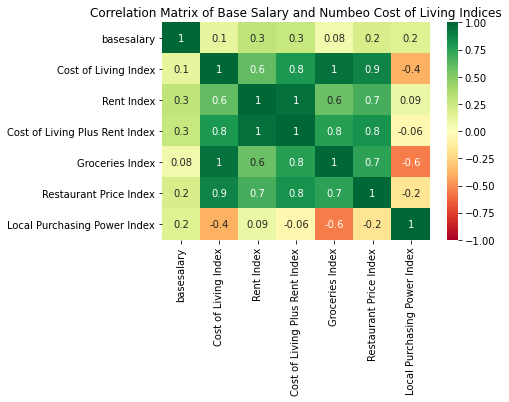

In [ ]:
import seaborn as sns

cols = ["basesalary", "Cost of Living Index", "Rent Index", "Cost of Living Plus Rent Index", "Groceries Index", "Restaurant Price Index", "Local Purchasing Power Index"]
sns.heatmap(df[cols].corr(), annot = True, fmt = '.1g', vmin=-1, vmax=1, center= 0, cmap= 'RdYlGn').set_title("Correlation Matrix of Base Salary and Numbeo Cost of Living Indices")

The above correlation matrix indicates that we have a slight positive relationship between base salary and every Numbeo index. The strongest relationships base salary has appear to be with Rent Index and Cost of Living Plus Rent Index, with correlations of 0.3. We'll focus on just the rent index. 

We've seen what the highest paying cities are, and we've seen the strong correlation between rent index and base salaries. Now, we're going to combine these two pieces of information together in a histogram below, which graphs the rent index of the 20 highest paying cities. 

In [ ]:
# Top 20 cities
fig = px.bar(summary_df.nlargest(20, "basesalary_mean"), x = 'City', y = 'Rent Index',
            color = 'basesalary_mean', labels = {
                 'basesalary_mean':'Average Base Salary'
                 }, height = 400)
fig.show()

In [ ]:
# Why is San Francisco so much more expensive compared to Oakland and San Jose ?

# Maybe it could be the number of companies there and population?
# We could easily run some aggregate operations to get a count of companies, but population may be annoying


This plot highlights certain cities as being relatively expensive to live in compared to cities that pay similarly. San Francisco pays the most, but it is also extremely expensive to live in. Meanwhile, cities like New York, Boston, and Washington DC show peaks in the graph, indicating that they are relatively expensive to live in given their average salaries compared to similar cities. 

# Regression and Machine Learning

Now that we have analyzed the data, we can begin using the analysis to make predictions about a person's salary based on their role, years of experience, and the cost of living in the city they are in. 

In [ ]:
from statsmodels.formula.api import ols

# These are the cities with an adequate number of obersvations (>= 30)
cities = summary_df.City.tolist()

# should we add interaction term as years of experience and title may be related ?
model = ols(formula = "basesalary ~ title + yearsofexperience + Q('Cost of Living Plus Rent Index') + City", data = df[df["City"].isin(cities)])
reg = model.fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             basesalary   R-squared:                       0.472
Model:                            OLS   Adj. R-squared:                  0.471
Method:                 Least Squares   F-statistic:                     591.7
Date:                Mon, 21 Dec 2020   Prob (F-statistic):               0.00
Time:                        02:31:39   Log-Likelihood:            -1.2829e+05
No. Observations:               26567   AIC:                         2.567e+05
Df Residuals:                   26526   BIC:                         2.570e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=========================================================================================================
                                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Intercept                                19.1012      2.788      6.851      0.000      13.637      24.566
title[T.Product Designer]               -13.2676      1.412     -9.398      0.000     -16.035     -10.501
title[T.Product Manager]                 -4.9338      1.098     -4.495      0.000      -7.085      -2.783
title[T.Software Engineer]               -5.5669      0.910     -6.119      0.000      -7.350      -3.784
title[T.Software Engineering Manager]     9.2180      1.192      7.735      0.000       6.882      11.554
title[T.Solution Architect]             -11.5885      1.717     -6.748      0.000     -14.954      -8.223
title[T.Technical Program Manager]      -16.1055      1.562    -10.309      0.000     -19.168     -13.043
City[T.Austin, TX]                       15.4732      2.487      6.222      0.000      10.598      20.348
City[T.Boston, MA]                       -9.9959      2.287     -4.370      0.000     -14.480      -5.512
City[T.Charlotte, NC]                     7.3544      4.874      1.509      0.131      -2.199      16.908
City[T.Chicago, IL]                      -0.4162      2.730     -0.152      0.879      -5.767       4.935
City[T.Columbus, OH]                      3.9447      5.236      0.753      0.451      -6.317      14.207
City[T.Dallas, TX]                        6.2496      2.691      2.322      0.020       0.975      11.525
City[T.Denver, CO]                        4.9641      3.441      1.443      0.149      -1.781      11.709
City[T.Detroit, MI]                       2.0738      5.144      0.403      0.687      -8.009      12.156
City[T.Fort Lauderdale, FL]              -8.7532      5.591     -1.565      0.117     -19.712       2.206
City[T.Houston, TX]                       5.7836      3.726      1.552      0.121      -1.519      13.086
City[T.Irvine, CA]                       -6.7498      3.255     -2.074      0.038     -13.130      -0.370
City[T.Kansas City, MO]                  -8.1745      4.376     -1.868      0.062     -16.752       0.403
City[T.Little Rock, AR]                  29.5350      5.356      5.514      0.000      19.037      40.033
City[T.Los Angeles, CA]                  16.4869      2.514      6.558      0.000      11.560      21.414
City[T.Madison, WI]                      20.7152      4.647      4.458      0.000      11.607      29.823
City[T.Minneapolis, MN]                   0.6332      3.465      0.183      0.855      -6.159       7.425
City[T.New York, NY]                     -8.9914      2.077     -4.329      0.000     -13.062      -4.921
City[T.Oakland, CA]                       7.1971      3.043      2.365      0.018       1.233      13.161
City[T.Orlando, FL]                     -12.5412      5.767     -2.175      0.030     -23.845      -1.238
City[T.Ph

In [ ]:
# Algorithm to rank top cities for you based on your qualifications and desired job

# These are the cities with an adequate number of obersvations (>= 30)
cities = summary_df.City.tolist()

# we could also maybe do 10-fold here ?
def rank_cities(job_title, years_of_experience):
  # let's return a pandas dataframe that includes: Job Title, Expected Salary, City, and Cost of Living
  # Will be sorted on salary
  # we can then use this same output to determine bang-for-your-buck if we have time
  result = pd.DataFrame(columns = ["title", "expectedbasesalary", "city", "costofliving"])

  numbeo_with_desired_cities = numbeo[numbeo["City"].isin(cities)]
  # iterate the rows of our desired cities to extract cost of living
  for index, row in numbeo_with_desired_cities.iterrows():
    params = pd.DataFrame.from_dict({
        "title": [job_title], 
        "yearsofexperience": [years_of_experience],
        "Cost of Living Plus Rent Index": [row["Cost of Living Plus Rent Index"]],
        "City": [row["City"]]
    })
    
    prediction = reg.predict(params)
    result.loc[len(result)] = [job_title, prediction[0], row["City"], row["Cost of Living Plus Rent Index"]]
  
  return result.sort_values(by = ["expectedbasesalary"], ascending = False)

test = rank_cities("Software Engineer", 2)
test.head()

title  expectedbasesalary               city  costofliving
1   Software Engineer          153.481612  San Francisco, CA        100.72
16  Software Engineer          147.773469       San Jose, CA         79.39
0   Software Engineer          142.132816       New York, NY        100.00
2   Software Engineer          138.016947        Oakland, CA         84.37
11  Software Engineer          135.199398    Los Angeles, CA         75.05

# Conclusion

Based on this 